In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.colors as mcolors
import logging
import os
from tqdm import tqdm
from icecream import ic

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [2]:
# Step 2: Extract and Visualize Data from alldat.
# Load Data

# Filenames corresponding to the URLs
filenames = [
    'steinmetz_part1.npz',
    'steinmetz_part2.npz',
    'steinmetz_part3.npz'
]

file_directory = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\NEURONS"

# Function to load data from npz files
def load_data(filenames):
    alldat = np.array([])
    for filename in filenames:
        data = np.load(os.path.join(file_directory,filename), allow_pickle=True)['dat']
        alldat = np.hstack((alldat, data))
    return alldat

# Download data if not already present
# download_data(urls, filenames)

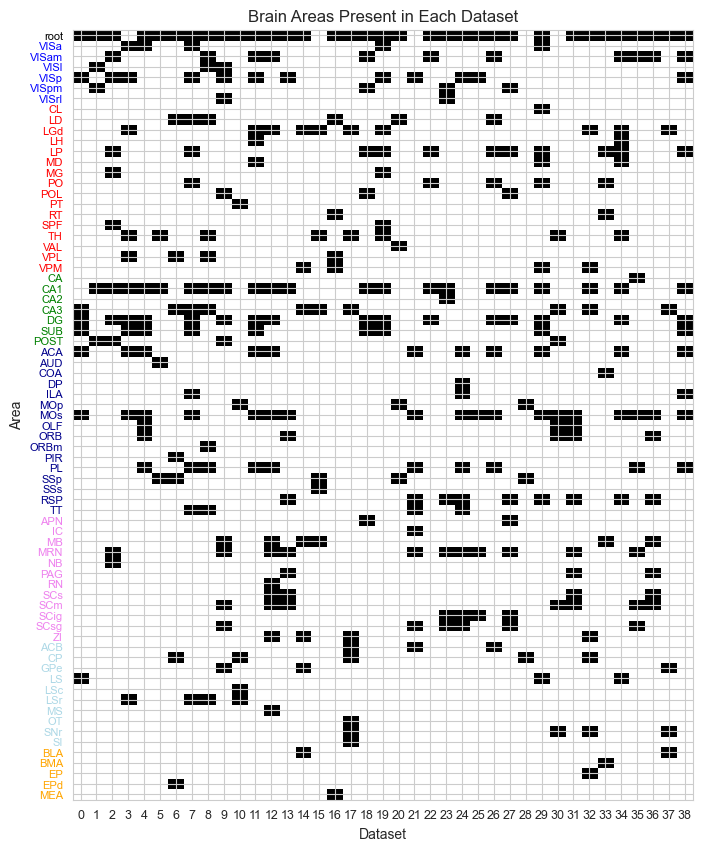

In [3]:
# Function to plot brain areas present in each dataset
def plot_brain_areas(data):
    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                    ]

    # Assign Each Area an Index
    area_to_index = dict(root=0)
    counter = 1
    for group in brain_groups:
        for area in group:
            area_to_index[area] = counter
            counter += 1

    # Determine Areas in Each Dataset
    areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
    for j, d in enumerate(data):
        for area in np.unique(d['brain_area']):
            i = area_to_index.get(area, -1)
            if i != -1:
                areas_by_dataset[i, j] = True

    # Visualize the Presence of Neurons in Different Regions Across Datasets
    plt.figure(figsize=(8, 10))
    plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

    # Label the Axes
    plt.xlabel("Dataset")
    plt.ylabel("Area")

    # Add Tick Labels
    yticklabels = ["root"]
    for group in brain_groups:
        yticklabels.extend(group)
    plt.yticks(np.arange(counter), yticklabels, fontsize=8)
    plt.xticks(np.arange(len(data)), fontsize=9)

    # Color the Tick Labels by Region
    ytickobjs = plt.gca().get_yticklabels()
    ytickobjs[0].set_color("black")
    counter = 1
    for group, color in zip(brain_groups, region_colors):
        for area in group:
            ytickobjs[counter].set_color(color)
            counter += 1

    plt.title("Brain Areas Present in Each Dataset")
    plt.grid(True)
    plt.show()

# Plot brain areas present in each dataset
alldat = load_data(filenames)
plot_brain_areas(alldat)

In [4]:
alldat = load_data(filenames)

In [5]:
print(alldat[0].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
len(alldat[1]['brain_area'])

1070

In [7]:
hpc = ["CA1", "CA3", "DG", "SUB"]
pfc = ["ACA", "ILA", "PL","RSP"]

In [8]:
region_loop = hpc + pfc
print(region_loop)

['CA1', 'CA3', 'DG', 'SUB', 'ACA', 'ILA', 'PL', 'RSP']


In [9]:
plot_dict = {x : np.array([]).reshape(0,250) for x in region_loop}
print(plot_dict)

{'CA1': array([], shape=(0, 250), dtype=float64), 'CA3': array([], shape=(0, 250), dtype=float64), 'DG': array([], shape=(0, 250), dtype=float64), 'SUB': array([], shape=(0, 250), dtype=float64), 'ACA': array([], shape=(0, 250), dtype=float64), 'ILA': array([], shape=(0, 250), dtype=float64), 'PL': array([], shape=(0, 250), dtype=float64), 'RSP': array([], shape=(0, 250), dtype=float64)}


In [10]:
for key in tqdm(plot_dict.keys()):
    ic(key)
    pos_feedback = np.empty((0,250))
    neg_feedback = np.empty((0,250))
    for i in range(len(alldat)):
        spikes_mask = np.array(alldat[i]['brain_area']) == key
        if np.any(spikes_mask):
            for n in np.array([1,-1]):
                feedback_mask= alldat[i]['feedback_type'].astype(int) == n
                spikes = alldat[i]['spks'][spikes_mask][:,feedback_mask].reshape(-1,250)
                if n == 1:
                    pos_feedback = np.vstack((pos_feedback, spikes))
                else:
                    neg_feedback = np.vstack((neg_feedback, spikes))
        else:
            continue
    plot_dict[key] = np.vstack([np.mean(pos_feedback, axis=0),np.mean(neg_feedback, axis=0)])
    ic(plot_dict[key].shape)
    ic("="*50)

  0%|          | 0/8 [00:00<?, ?it/s]ic| key: 'CA1'
ic| plot_dict[key].shape: (2, 250)
ic| "="*50: '=================================================='
 12%|█▎        | 1/8 [00:01<00:09,  1.41s/it]ic| key: 'CA3'
ic| plot_dict[key].shape: (2, 250)
ic| "="*50: '=================================================='
 25%|██▌       | 2/8 [00:01<00:04,  1.34it/s]ic| key: 'DG'
ic| plot_dict[key].shape: (2, 250)
ic| "="*50: '=================================================='
 38%|███▊      | 3/8 [00:02<00:03,  1.56it/s]ic| key: 'SUB'
ic| plot_dict[key].shape: (2, 250)
ic| "="*50: '=================================================='
 50%|█████     | 4/8 [00:02<00:02,  1.99it/s]ic| key: 'ACA'
ic| plot_dict[key].shape: (2, 250)
ic| "="*50: '=================================================='
 62%|██████▎   | 5/8 [00:02<00:01,  2.07it/s]ic| key: 'ILA'
ic| plot_dict[key].shape: (2, 250)
ic| "="*50: '=================================================='
 75%|███████▌  | 6/8 [00:03<00:00,  2.78it/s]ic| 

In [11]:
# # Define base colors
# hippocampus_base = '#0000FF'  # Blue
# prefrontal_base = '#00FF00'  # Green
# 
# # Create color maps
# hippocampus_cmap = plt.cm.Blues
# prefrontal_cmap = plt.cm.Greens
# 
# # Generate color gradients
# hippocampus_colors = hippocampus_cmap(np.linspace(0.3, 1, 5))
# prefrontal_colors = prefrontal_cmap(np.linspace(0.3, 1, 5))
# 
# 
# color_scheme = {
#     'CA1': hippocampus_colors[0],
#     'CA2': hippocampus_colors[1],
#     'CA3': hippocampus_colors[2],
#     'Dentate Gyrus': hippocampus_colors[3],
#     'Subiculum': hippocampus_colors[4],
#     'Dorsolateral PFC': prefrontal_colors[0],
#     'Ventrolateral PFC': prefrontal_colors[1],
#     'Medial PFC': prefrontal_colors[2],
#     'Orbitofrontal Cortex': prefrontal_colors[3],
#     'Anterior Cingulate Cortex': prefrontal_colors[4]
# }
# 
# # Example plot dictionary (replace this with your actual data)
# plot_dict = {
#     'CA1': np.random.rand(2, 250),
#     'CA2': np.random.rand(2, 250),
#     'CA3': np.random.rand(2, 250),
#     'Dentate Gyrus': np.random.rand(2, 250),
#     'Subiculum': np.random.rand(2, 250),
#     'Dorsolateral PFC': np.random.rand(2, 250),
#     'Ventrolateral PFC': np.random.rand(2, 250),
#     'Medial PFC': np.random.rand(2, 250),
#     'Orbitofrontal Cortex': np.random.rand(2, 250),
#     'Anterior Cingulate Cortex': np.random.rand(2, 250)
# }
# 
# # Create the plot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# fig.suptitle('Brain Region Activity: Positive vs Negative Trials', fontsize=16)
# 
# x = np.arange(250)
# 
# for region, data in plot_dict.items():
#     ax1.plot(x, data[0], color=color_scheme[region], label=region, linewidth=2)
#     ax2.plot(x, data[1], color=color_scheme[region], label=region, linewidth=2)
# 
# ax1.set_title('Positive Trials')
# ax1.set_ylabel('Activity')
# ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax1.grid(True, linestyle='--', alpha=0.7)
# 
# ax2.set_title('Negative Trials')
# ax2.set_xlabel('Time')
# ax2.set_ylabel('Activity')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax2.grid(True, linestyle='--', alpha=0.7)
# 
# plt.tight_layout()
# plt.show()


In [12]:
save_dir = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\figures"

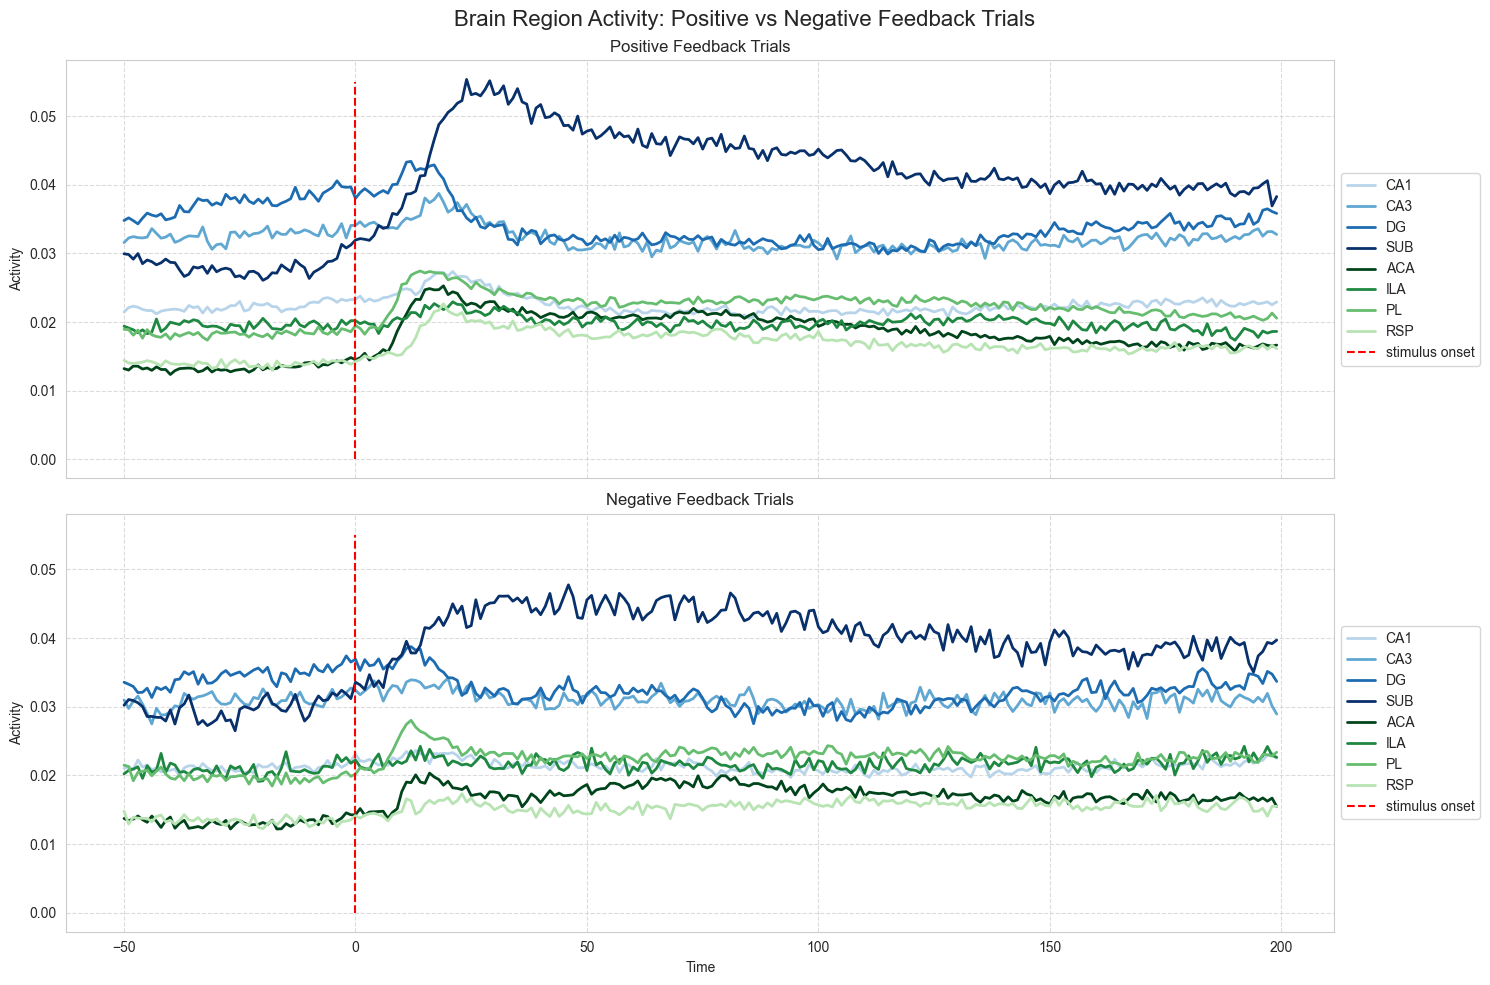

In [13]:
# Define base colors
hippocampus_base = '#0000FF'  # Blue
prefrontal_base = '#00FF00'  # Green

# Create color maps
hippocampus_cmap = plt.cm.Blues
prefrontal_cmap = plt.cm.Greens

# Generate color gradients
hippocampus_colors = hippocampus_cmap(np.linspace(0.3, 1, len(hpc)))
prefrontal_colors = prefrontal_cmap(np.linspace(0.3, 1, len(pfc)))

hpc = ["CA1", "CA3", "DG", "SUB"]
pfc = ["ACA", "ILA", "PL", "RSP"]
color_scheme = {
    'CA1': hippocampus_colors[0],
    'CA3': hippocampus_colors[1],
    'DG': hippocampus_colors[2],
    'SUB': hippocampus_colors[3],
    'ACA': prefrontal_colors[3],
    'ILA': prefrontal_colors[2],
    'PL': prefrontal_colors[1],
    'RSP': prefrontal_colors[0]
}

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Brain Region Activity: Positive vs Negative Feedback Trials', fontsize=16)

x = np.arange(-50,200,1)

for region, data in plot_dict.items():
    ax1.plot(x, data[0], color=color_scheme[region], label=region, linewidth=2)
    ax2.plot(x, data[1], color=color_scheme[region], label=region, linewidth=2)

ax1.vlines(0,0,0.055,linestyles='dashed', label ='stimulus onset', color='red')
ax1.set_title('Positive Feedback Trials')
ax1.set_ylabel('Activity')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, linestyle='--', alpha=0.7)

ax2.vlines(0,0,0.055,linestyles='dashed', label ='stimulus onset', color='red')
ax2.set_title('Negative Feedback Trials')
ax2.set_xlabel('Time')
ax2.set_ylabel('Activity')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(save_dir, 'brain_region_activity'))